In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

/home/nqmtien/miniconda3/envs/REIT4841/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('../cbm/img-reason_paragraphs-raw-label.json', 'r') as f:
    label_data = json.load(f)

with open('../cbm/img-reason_paragraphs-raw-no_label.json', 'r') as f:
    no_label_data = json.load(f)

print(f"Number of entries in label data: {len(label_data)}")
print(f"Number of entries in no-label data: {len(no_label_data)}")


Number of entries in label data: 5198
Number of entries in no-label data: 5198


In [3]:
df_label = pd.DataFrame(label_data)
df_no_label = pd.DataFrame(no_label_data)

In [4]:
df_label['source'] = 'with_label'
df_no_label['source'] = 'no_label'

In [5]:
print("\nSample from labeled data:")
print(df_label.head(2))
print("\nSample from unlabeled data:")
print(df_no_label.head(2))


Sample from labeled data:
       image_id pred                                             reason  \
0  ISIC_0033818   NV  The dermoscopic image reveals a well-defined, ...   
1  ISIC_0024615   NV  The dermoscopic image displays a well-defined,...   

       source  
0  with_label  
1  with_label  

Sample from unlabeled data:
       image_id pred                                             reason  \
0  ISIC_0033818  MEL  The dermoscopic image reveals a lesion with a ...   
1  ISIC_0024615   NV  The dermoscopic image displays a relatively un...   

     source  
0  no_label  
1  no_label  


In [14]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Rejoin into a string
    return ' '.join(tokens)

# Apply preprocessing
df_label['processed_text'] = df_label['reason'].apply(preprocess_text)
df_no_label['processed_text'] = df_no_label['reason'].apply(preprocess_text)

df_combined = pd.merge(df_label, df_no_label, on='image_id')
df_combined = df_combined.rename(columns={'pred_x': 'true_label', 'pred_y': 'predicted_label', 
                                         'reason_x': 'reason_w_label', 'reason_y': 'reason_no_label',
                                         'processed_text_x': 'processed_text_w_label', 'processed_text_y': 'processed_text_no_label'})
df_combined = df_combined.drop(columns=['source_x', 'source_y'])

In [15]:
df_combined

,image_id,true_label,reason_w_label,processed_text_w_label,predicted_label,reason_no_label,processed_text_no_label
0,ISIC_0033818,NV,"The dermoscopic image reveals a well-defined, ...",dermoscopic image reveals well defined somewha...,MEL,The dermoscopic image reveals a lesion with a ...,dermoscopic image reveals lesion somewhat irre...
1,ISIC_0024615,NV,"The dermoscopic image displays a well-defined,...",dermoscopic image displays well defined ovoid ...,NV,The dermoscopic image displays a relatively un...,dermoscopic image displays relatively uniform ...
2,ISIC_0031134,NV,"The dermoscopic image reveals a well-defined, ...",dermoscopic image reveals well defined pigment...,MEL,The dermoscopic image reveals a lesion exhibit...,dermoscopic image reveals lesion exhibiting se...
3,ISIC_0031134,NV,"The dermoscopic image reveals a well-defined, ...",dermoscopic image reveals well defined pigment...,MEL,The dermoscopic image displays a lesion charac...,dermoscopic image displays lesion characterize...
4,ISIC_0027538,NV,"The dermoscopic image presents a well-defined,...",dermoscopic image presents well defined slight...,MEL,This dermoscopic image presents with several c...,dermoscopic image presents several concerning ...
...,...,...,...,...,...,...,...
9279,ISIC_0027503,NV,The dermoscopic image exhibits a classic nevus...,dermoscopic image exhibits classic nevus appea...,MEL,The lesion demonstrates several features sugge...,lesion demonstrates several features suggestiv...
9280,ISIC_0027503,NV,The dermoscopic image exhibits a classic nevus...,dermoscopic image exhibits classic nevus appea...,MEL,This dermoscopic image displays several featur...,dermoscopic image displays several features su...
9281,ISIC_0030176,NV,"The dermoscopic image displays a well-defined,...",dermoscopic image displays well defined pigmen...,NV,The dermoscopic image displays a lesion with a...,dermoscopic image displays lesion predominantl...
9282,ISIC_0031798,NV,The lesion demonstrates a classic melanocytic ...,lesion demonstrates classic melanocytic nevus ...,MEL,The lesion exhibits a significant degree of as...,lesion exhibits significant degree asymmetry o...


[('lesion', 16808), ('nevus', 16718), ('melanocytic', 13591), ('nevi', 8312), ('pigment', 7739), ('brown', 7319), ('relatively', 7133), ('significant', 6993), ('pattern', 6560), ('irregular', 6394), ('overall', 6112), ('typical', 5992), ('well', 5929), ('features', 5898), ('structures', 5879), ('benign', 5874), ('dermoscopic', 5514), ('color', 5485), ('defined', 5314), ('common', 5300)]

Most common words by category:
   MEL (with label) NV (with label) MEL (no label) NV (no label)
0          melanoma          lesion         lesion        lesion
1            lesion           nevus       melanoma      melanoma
2         irregular     melanocytic      irregular     irregular
3           pigment            nevi       features      features
4              dark         pigment    significant   melanocytic
5          presence           brown        pigment   significant
6          features      relatively           dark       pigment
7       significant     significant    melanocytic        

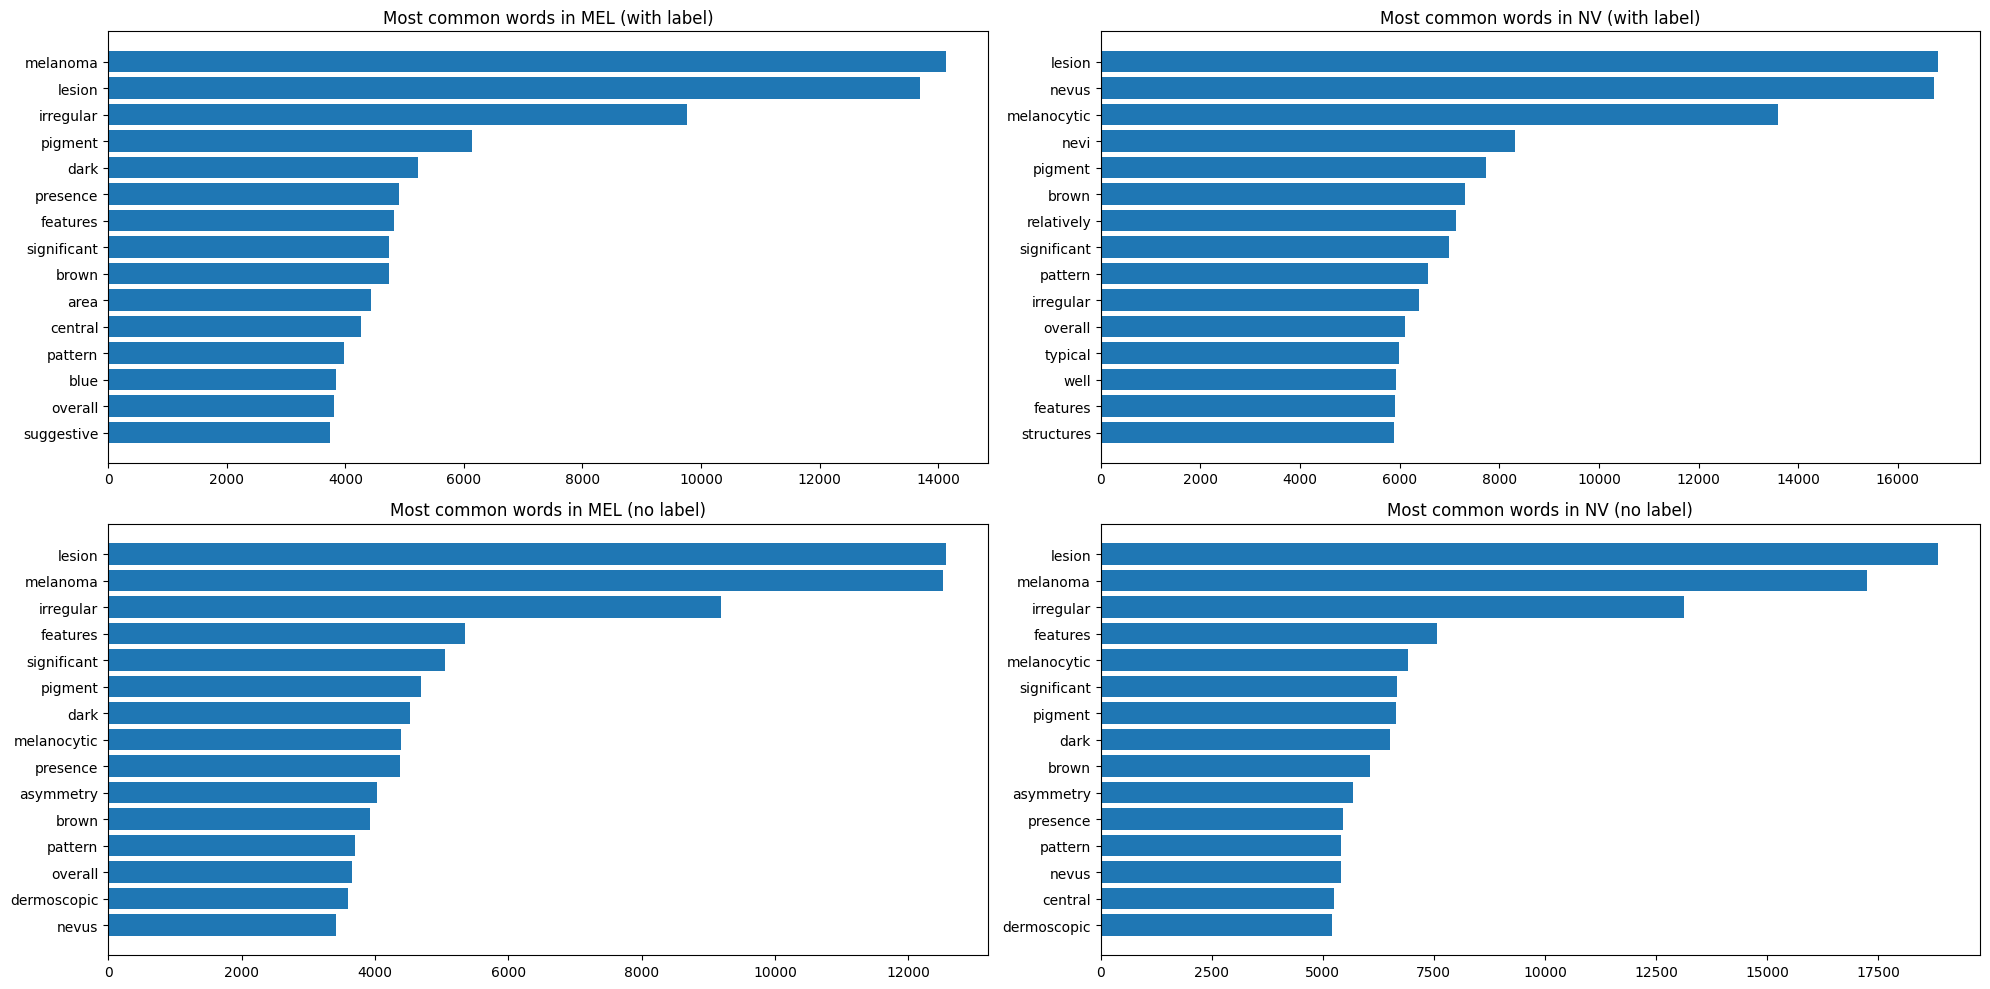

In [ ]:
def get_top_words(texts, n=20):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

# Get top words for each label category in both datasets
mel_with_label = df_combined[df_combined['true_label'] == 'MEL']['processed_text_w_label']
mel_no_label = df_combined[df_combined['true_label'] == 'MEL']['processed_text_no_label']
nv_with_label = df_combined[df_combined['true_label'] == 'NV']['processed_text_w_label']
nv_no_label = df_combined[df_combined['true_label'] == 'NV']['processed_text_no_label']

top_mel_with_label = get_top_words(mel_with_label)
top_nv_with_label = get_top_words(nv_with_label)
top_mel_no_label = get_top_words(mel_no_label)
top_nv_no_label = get_top_words(nv_no_label)

# Create a DataFrame to display the results side by side
top_words_df = pd.DataFrame({
    'MEL (with label)': [word for word, count in top_mel_with_label],
    'NV (with label)': [word for word, count in top_nv_with_label],
    'MEL (no label)': [word for word, count in top_mel_no_label],
    'NV (no label)': [word for word, count in top_nv_no_label]
})

print("\nMost common words by category:")
print(top_words_df.head(20))

# Plot most common words
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.barh([word for word, _ in top_mel_with_label[:15]][::-1], 
         [count for _, count in top_mel_with_label[:15]][::-1])
plt.title('Most common words in MEL (with label)')

plt.subplot(2, 2, 2)
plt.barh([word for word, _ in top_nv_with_label[:15]][::-1], 
         [count for _, count in top_nv_with_label[:15]][::-1])
plt.title('Most common words in NV (with label)')

plt.subplot(2, 2, 3)
plt.barh([word for word, _ in top_mel_no_label[:15]][::-1], 
         [count for _, count in top_mel_no_label[:15]][::-1])
plt.title('Most common words in MEL (no label)')

plt.subplot(2, 2, 4)
plt.barh([word for word, _ in top_nv_no_label[:15]][::-1], 
         [count for _, count in top_nv_no_label[:15]][::-1])
plt.title('Most common words in NV (no label)')

plt.tight_layout()
plt.show()

Embedding 3883 unique keywords...


Batches: 100%|██████████| 122/122 [00:01<00:00, 82.62it/s] 


Running t-SNE with perplexity: 30 for 3883 samples.


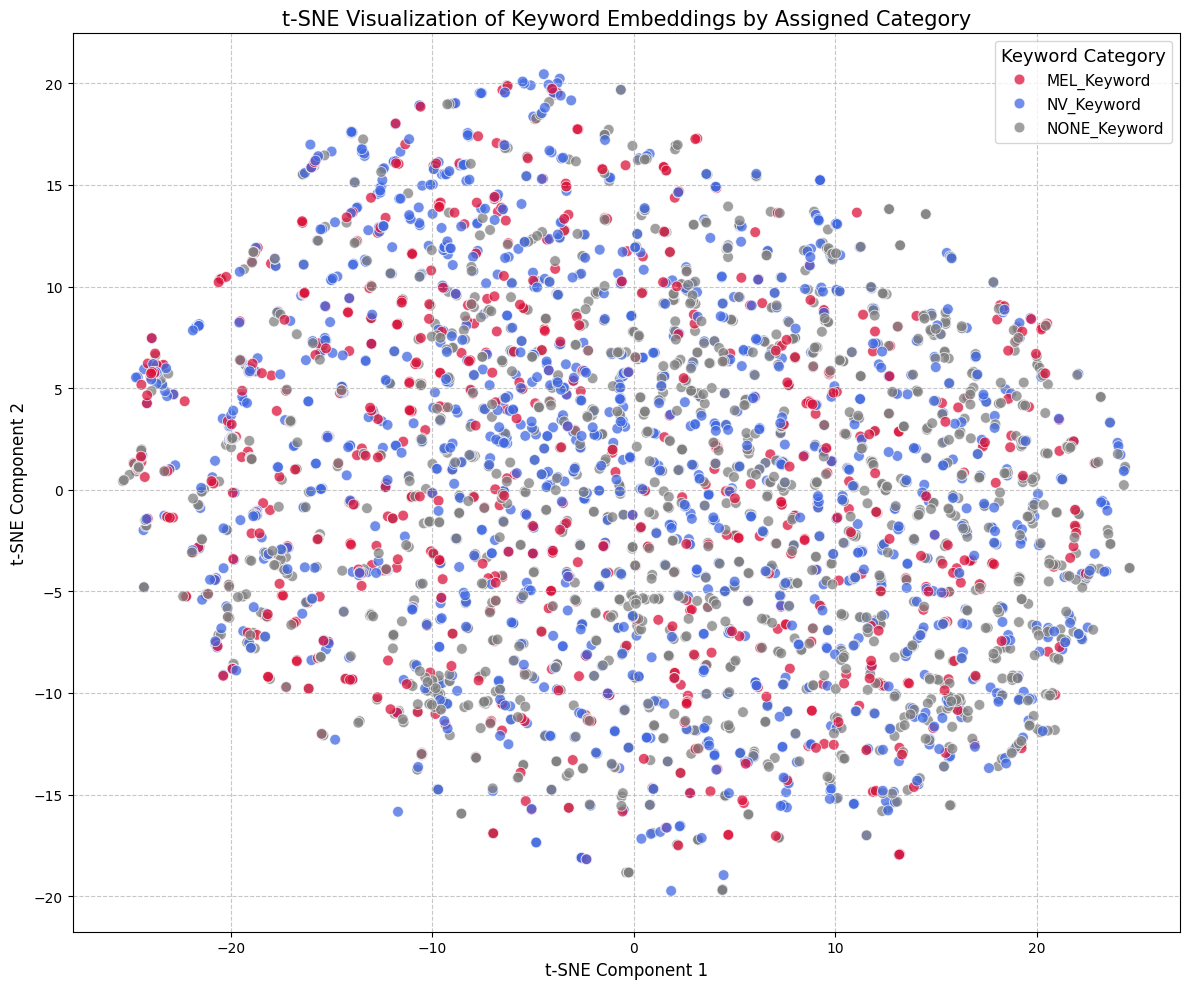


Keyword category counts:
category
NONE_Keyword    1767
NV_Keyword      1376
MEL_Keyword      740
Name: count, dtype: int64


In [28]:
model = SentenceTransformer('all-MiniLM-L6-v2')
keyword_label_pairs = []
for _, row in df_combined.iterrows():
    current_true_label = row['true_label']
    
    # Keywords from processed_text_w_label
    words_from_w_label = str(row['processed_text_w_label']).split() # Ensure it's a string
    for word in words_from_w_label:
        if word: # Ensure word is not empty
            keyword_label_pairs.append({'keyword': word, 'label': current_true_label})
            
    # Keywords from processed_text_no_label
    words_from_no_label = str(row['processed_text_no_label']).split() # Ensure it's a string
    for word in words_from_no_label:
        if word: # Ensure word is not empty
            keyword_label_pairs.append({'keyword': word, 'label': current_true_label})

if not keyword_label_pairs:
    print("No keyword-label pairs were extracted. Please check your 'processed_text_w_label' and 'processed_text_no_label' columns in df_combined.")
else:
    df_keyword_occurrences = pd.DataFrame(keyword_label_pairs)

    # --- 3. Process keyword_label_pairs to get label distributions ---
    # Count occurrences of each label (MEL, NV) for each keyword
    keyword_label_counts = df_keyword_occurrences.groupby('keyword')['label'].value_counts().unstack(fill_value=0)

    # Ensure both MEL and NV columns exist
    if 'MEL' not in keyword_label_counts.columns:
        keyword_label_counts['MEL'] = 0
    if 'NV' not in keyword_label_counts.columns:
        keyword_label_counts['NV'] = 0
        
    keyword_label_counts['total_occurrences'] = keyword_label_counts['MEL'] + keyword_label_counts['NV']

    # Calculate percentages
    # Avoid division by zero if a keyword somehow has 0 total_occurrences (should not happen with current logic)
    keyword_label_counts['MEL_perc'] = np.where(keyword_label_counts['total_occurrences'] > 0, keyword_label_counts['MEL'] / keyword_label_counts['total_occurrences'], 0)
    keyword_label_counts['NV_perc'] = np.where(keyword_label_counts['total_occurrences'] > 0, keyword_label_counts['NV'] / keyword_label_counts['total_occurrences'], 0)

    # --- 4. Assign final label to keywords ---
    def assign_final_keyword_label(row):
        if row['MEL_perc'] > 0.75:
            return 'MEL_Keyword'
        elif row['NV_perc'] > 0.75:
            return 'NV_Keyword'
        else:
            return 'NONE_Keyword'

    keyword_label_counts['final_keyword_label'] = keyword_label_counts.apply(assign_final_keyword_label, axis=1)
    
    # Optional: Filter out keywords with very few occurrences if the plot is too noisy
    # min_occurrences = 3 # Example threshold
    # keyword_label_counts = keyword_label_counts[keyword_label_counts['total_occurrences'] >= min_occurrences]

    if keyword_label_counts.empty:
        print("No keywords remaining after processing (e.g., after filtering or if no keywords met criteria).")
    else:
        # --- 5. Get embeddings for unique keywords ---
        unique_keywords_list = keyword_label_counts.index.tolist()
        
        if not unique_keywords_list:
            print("No unique keywords to embed.")
        else:
            print(f"Embedding {len(unique_keywords_list)} unique keywords...")
            keyword_embeddings_array = model.encode(unique_keywords_list, show_progress_bar=True)

            # --- 6. Apply t-SNE ---
            n_samples = keyword_embeddings_array.shape[0]
            
            if n_samples <= 1:
                print(f"Not enough keyword samples ({n_samples}) for t-SNE. Skipping t-SNE visualization for keywords.")
            else:
                # Perplexity should be less than n_samples. Max 50 is often recommended.
                perplexity_value = min(30, n_samples - 1) 
                print(f"Running t-SNE with perplexity: {perplexity_value} for {n_samples} samples.")
                
                tsne_model_keywords = TSNE(n_components=2, 
                                           random_state=42, 
                                           perplexity=perplexity_value, 
                                           n_iter=300, # Lower for faster, 1000 is default
                                           init='pca', # PCA initialization can be more stable
                                           learning_rate='auto') # Added in newer sklearn
                tsne_results_keywords = tsne_model_keywords.fit_transform(keyword_embeddings_array)

                # --- 7. Create a DataFrame for visualization ---
                df_tsne_keywords_viz = pd.DataFrame({
                    'keyword': unique_keywords_list,
                    'tsne_x': tsne_results_keywords[:, 0],
                    'tsne_y': tsne_results_keywords[:, 1],
                    'category': keyword_label_counts.loc[unique_keywords_list, 'final_keyword_label'].values
                })

                # --- 8. Plot the t-SNE results for keywords ---
                plt.figure(figsize=(12, 10))
                sns.scatterplot(
                    x='tsne_x', y='tsne_y',
                    hue='category',
                    palette={'MEL_Keyword': 'crimson', 'NV_Keyword': 'royalblue', 'NONE_Keyword': 'grey'},
                    data=df_tsne_keywords_viz,
                    alpha=0.75,
                    s=60 # marker size
                )
                plt.title('t-SNE Visualization of Keyword Embeddings by Assigned Category', fontsize=15)
                plt.xlabel('t-SNE Component 1', fontsize=12)
                plt.ylabel('t-SNE Component 2', fontsize=12)
                plt.legend(title='Keyword Category', title_fontsize='13', fontsize='11')
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()

                print("\nKeyword category counts:")
                print(df_tsne_keywords_viz['category'].value_counts())

This sucks